# Machine Learning baseline

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from fastcore.basics import Path, AttrDict
import utils
import numpy as np
import pickle

# This is used to import the evaluation script, not needed for training
import sys
sys.path.append('../') 
import evaluation


In [2]:
config = AttrDict(
    challenge_data_dir = Path('../../dataset').expanduser(),
    valid_ratio = 0.1,
    lag_steps = 5
)

In [3]:
# Define the list of feature columns
feature_cols = ['Eccentricity', 'Semimajor axis (km)', 'Inclination (deg)', 
                'RAAN (deg)', 'Argument of periapsis (deg)', 'True anomaly (deg)', 
                'Latitude (deg)', 'Longitude (deg)', 'Altitude (km)', 'J2k X (km)', 
                'J2k Y (km)', 'J2k Z (km)', 'J2k Vx (km/s)', 'J2k Vy (km/s)', 
                'J2k Vz (km/s)']

In [4]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir, feature_cols, 
                                          ground_truth, lag_steps=config.lag_steps)

# For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)

,ObjectID,TimeIndex,EW,NS
0,1,0,SS-HK,SS-NK
1,1,1,SS-HK,SS-NK
0,3,0,SS-EK,SS-EK
1,3,1,SS-EK,SS-EK
0,2,0,SS-NK,SS-NK
1,2,1,SS-NK,SS-NK
0,5,0,SS-CK,SS-NK
1,5,1,SS-CK,SS-NK
0,4,0,SS-CK,SS-NK
1,4,1,SS-CK,SS-NK


In [5]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids, 
                                        test_size=config.valid_ratio, 
                                        random_state=42)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 4
Number of objects in the validation set: 1


Next we will make sure that there every label, both in the direction EW and NS,
is present both in the training and validation partitions

In [6]:
# Get the unique values of EW and NS in train and test data
train_EW = set(train_data['EW'].unique())
train_NS = set(train_data['NS'].unique())
valid_EW = set(train_data['EW'].unique())
valid_NS = set(valid_data['NS'].unique())

# Get the values of EW and NS that are in test data but not in train data
missing_EW = valid_EW.difference(train_EW)
missing_NS = valid_NS.difference(train_NS)

# Check if all the values in EW are also present in NS
if not set(train_data['EW'].unique()).issubset(set(train_data['NS'].unique())):
    # Get the values of EW that are not present in NS
    missing_EW_NS = set(train_data['EW'].unique()).difference(
        set(train_data['NS'].unique())
    )
else:
    missing_EW_NS = None

# Print the missing values of EW and NS
print("Missing values of EW in test data:", missing_EW)
print("Missing values of NS in test data:", missing_NS)
print("Values of EW not present in NS:", missing_EW_NS)


Missing values of EW in test data: set()
Missing values of NS in test data: {'SS-EK', 'IK-EK', 'ID-NK'}
Values of EW not present in NS: {'IK-CK', 'SS-HK', 'ID-NK', 'SS-CK', 'AD-NK'}


In [7]:
# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])

# Define the Random Forest model for EW
model_EW = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model to the training data for EW
model_EW.fit(train_data[updated_feature_cols], train_data['EW_encoded'])

# Define the Random Forest model for NS
model_NS = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model to the training data for NS
model_NS.fit(train_data[updated_feature_cols], train_data['NS_encoded'])

RandomForestClassifier(random_state=42)

In [8]:
# Make predictions on the training data for EW
train_data['Predicted_EW'] = le_EW.inverse_transform(
    model_EW.predict(train_data[updated_feature_cols])
)

# Make predictions on the validation data for NS
train_data['Predicted_NS'] = le_NS.inverse_transform(
    model_NS.predict(train_data[updated_feature_cols])
)

# Print the first few rows of the test data with predictions for both EW and NS
train_data[['TimeIndex', 'ObjectID', 'EW', 
            'Predicted_EW', 'NS', 'Predicted_NS']].groupby('ObjectID').head(3)

,TimeIndex,ObjectID,EW,Predicted_EW,NS,Predicted_NS
0,0,1,SS-HK,SS-HK,SS-NK,SS-NK
1,1,1,SS-HK,SS-HK,SS-NK,SS-NK
2,2,1,SS-HK,SS-HK,SS-NK,SS-NK
0,0,2,SS-NK,SS-NK,SS-NK,SS-NK
1,1,2,SS-NK,SS-NK,SS-NK,SS-NK
2,2,2,SS-NK,SS-NK,SS-NK,SS-NK
0,0,5,SS-CK,SS-CK,SS-NK,SS-NK
1,1,5,SS-CK,SS-CK,SS-NK,SS-NK
2,2,5,SS-CK,SS-CK,SS-NK,SS-NK
0,0,4,SS-CK,SS-CK,SS-NK,SS-NK


In [9]:
if config.valid_ratio > 0:
    # Make predictions on the validation data for EW
    valid_data['Predicted_EW'] = le_EW.inverse_transform(
        model_EW.predict(valid_data[updated_feature_cols])
    )

    # Make predictions on the validation data for NS
    valid_data['Predicted_NS'] = le_NS.inverse_transform(
        model_NS.predict(valid_data[updated_feature_cols])
    )

The `NodeDetectionEvaluator` class in the evaluation module allows not only to
compute the general score for a given dataset, but get evaluations per object, and
even plots that show how the predictions look like in a timeline

In [10]:
train_results = utils.convert_classifier_output(train_data)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')


Precision for the train set: 1.00
Recall for the train set: 0.77
F2 for the train set: 0.81
RMSE for the train set: 0.00


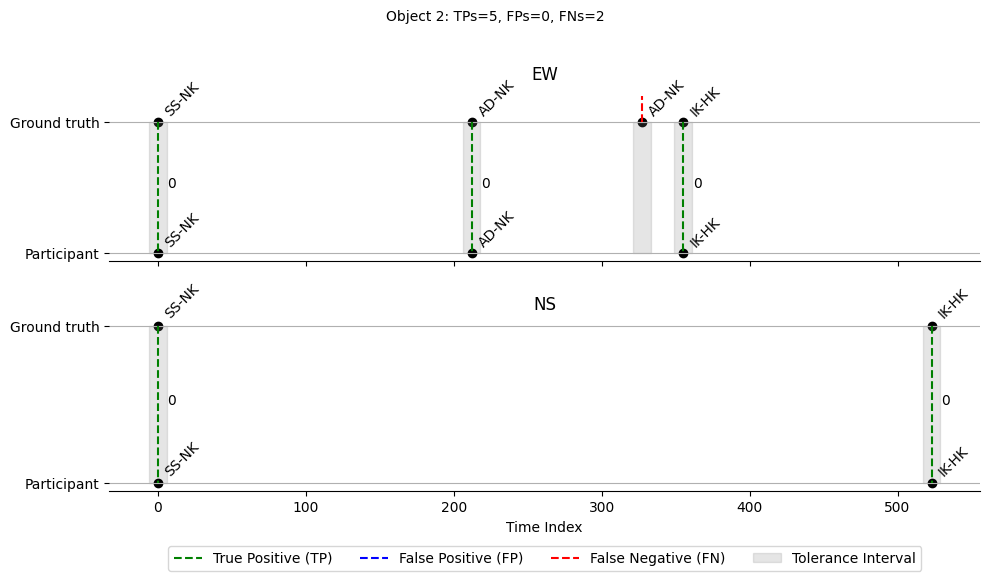

In [11]:
# Plot the evaluation timeline for a random ObjectID from the training set
evaluator.plot(np.random.choice(train_data['ObjectID'].unique()))

In [12]:
# Loop over the Object IDs in the training set and call the evaluation
# function for each object and aggregate the results
total_tp = 0
total_fp = 0
total_fn = 0
for oid in train_data['ObjectID'].unique():
    tp, fp, fn, gt_object, p_object = evaluator.evaluate(oid)
    total_tp += tp
    total_fp += fp
    total_fn += fn

print(f'Total true positives: {total_tp}')
print(f'Total false positives: {total_fp}')
print(f'Total false negatives: {total_fn}')

Total true positives: 17
Total false positives: 0
Total false negatives: 5


In [13]:
if config.valid_ratio > 0:
    valid_results = utils.convert_classifier_output(valid_data)
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, valid_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the validation set: {precision:.2f}')
print(f'Recall for the validation set: {recall:.2f}')
print(f'F2 for the validation set: {f2:.2f}')
print(f'RMSE for the validation set: {rmse:.2f}')

Precision for the validation set: 0.20
Recall for the validation set: 0.20
F2 for the validation set: 0.20
RMSE for the validation set: 3.54


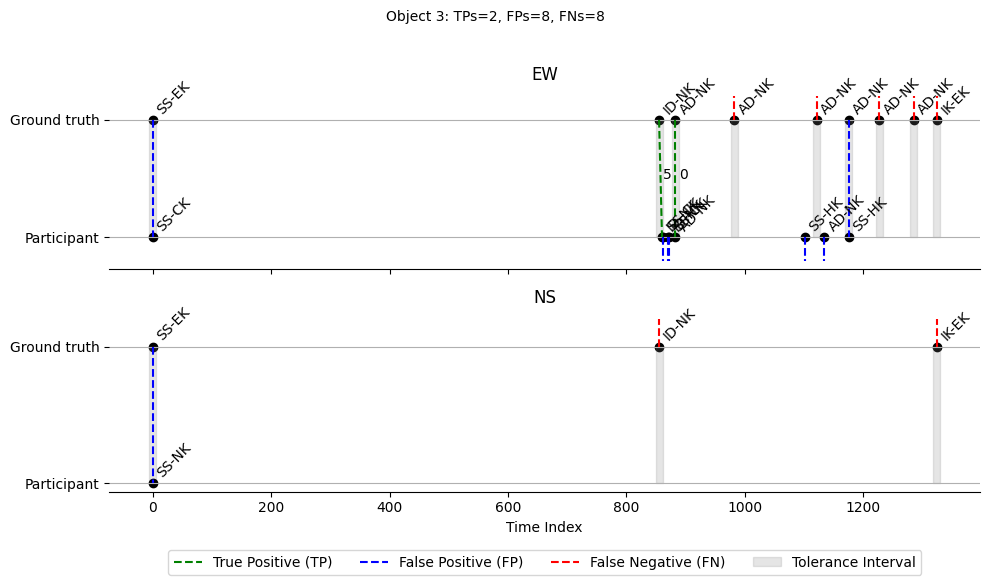

In [14]:
# Plot the evaluation timeline for a random ObjectID from the training set
evaluator.plot(np.random.choice(valid_data['ObjectID'].unique()))

In [15]:
# Save the trained random forest models (and label encoders) to disk
# Create the folder trained_model if it doesn't exist
Path('trained_model').mkdir(exist_ok=True)
pickle.dump(model_EW, open('trained_model/model_EW.pkl', 'wb'))
pickle.dump(model_NS, open('trained_model/model_NS.pkl', 'wb'))
pickle.dump(le_EW, open('trained_model/le_EW.pkl', 'wb'))
pickle.dump(le_NS, open('trained_model/le_NS.pkl', 'wb'))